# Кейс №2 - Приложение доставки.
Оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого выберем метрики, которые отвечают за качество сервиса, и статистически сравним эти метрики в двух группах. Наша главная задача заключается в том, чтобы пользователям было удобнее пользоваться приложением, а бизнес получил больше прибыли. В качестве целевых метрик возьмем средний чек пользователей и retention rate (показатель удержания).

### Этапы работы:
1. Выгрузка и предобработка данных.
2. Анализ целевой метрики 1.
3. Анализ целевой метрики 2.
4. Выводы.

### Этап 1. Выгрузка и предобработка данных.

In [113]:
# Импортируем требующиеся библиотеки.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from datetime import date
%matplotlib inline

In [114]:
# Устанавливаем размер графиков и шрифта.
sns.set(rc={'figure.figsize':(12, 8)})

In [115]:
# Считываем данные и смотрим на них.
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-belyj/A_B_tests/ab_orders.csv')
products = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-belyj/A_B_tests/ab_products.csv')
user_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-belyj/A_B_tests/ab_users_data.csv')

In [116]:
user_data

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1
...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0


In [117]:
orders

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"
...,...,...,...
4118,59422,2022-09-08 23:13:03.000000,"{84, 8, 24}"
4119,59439,2022-09-08 23:18:05.000000,"{9, 25, 75, 30, 6}"
4120,59464,2022-09-08 23:22:27.000000,"{60, 41, 46}"
4121,59487,2022-09-08 23:29:06.000000,"{9, 62, 77}"


In [118]:
products

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0
...,...,...,...
82,83,вафли,55.0
83,84,мандарины,90.4
84,85,варенье,200.3
85,86,кофе холодный,70.3


In [119]:
products.isna().sum()

product_id    0
name          0
price         0
dtype: int64

In [120]:
orders.isna().sum()

order_id         0
creation_time    0
product_ids      0
dtype: int64

In [121]:
user_data.isna().sum()

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

Пропусков в данных нет. Даты приведем к нужному формату, когда будем непосредственно работать с датами

### Этап 2. Анализ целевой метрики 1.
Чтобы найти средний чек пользователей, надо узать цену каждого заказа и сгруппировать по пользователям, найдя средний чек для каждого из них.

Гипотезы для целевой метрики 1:
<ul>
<li>H_0 - средний чек в контрольной и тестовой группах не отличается.
<li>H_1 - средний чек в контрольной и тестовой группах отличается.    

In [122]:
# Записываем id товаров в наших заказах в виде списка.
orders['product_ids'] = orders.product_ids.apply(lambda x: x.strip('}{').split(', '))

In [123]:
# Раскрываем список, записывая каждый товар в отдельной строке.
orders = orders.explode('product_ids').rename(columns={'product_ids':'product_id'})
orders['product_id'] = orders.product_id.apply(lambda x: int(x))

# Соединяем таблицу с информацией о заказах с таблицей с информацией о продуктах.
result_orders = orders.merge(products, on='product_id', how='left')
result_orders

,order_id,creation_time,product_id,name,price
0,1255,2022-08-26 00:00:19.000000,75,сок ананасовый,120.0
1,1255,2022-08-26 00:00:19.000000,22,сок мультифрукт,120.0
2,1255,2022-08-26 00:00:19.000000,53,мука,78.3
3,1255,2022-08-26 00:00:19.000000,84,мандарины,90.4
4,1256,2022-08-26 00:02:21.000000,56,сосиски,150.0
...,...,...,...,...,...
13821,59487,2022-09-08 23:29:06.000000,9,чай черный листовой,83.5
13822,59487,2022-09-08 23:29:06.000000,62,сок яблочный,120.0
13823,59487,2022-09-08 23:29:06.000000,77,курица,298.4
13824,59533,2022-09-08 23:41:24.000000,17,морс брусничный,190.0


In [124]:
# Группируем по ордеру и находим полную цену каждого заказа.
result_orders = result_orders.groupby('order_id', as_index=False) \
                             .agg({'price':'sum'})

# Соединяем таблицу с информацией с заказами по каждому юзеру с таблицей, которую получили выше (с ценами за заказ).
result_orders = user_data.merge(result_orders, on='order_id', how='left')
result_orders

,user_id,order_id,action,time,date,group,price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,408.7
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,250.5
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,310.2
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,85.0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,228.0
...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1,241.2
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1,518.5
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0,185.9
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,501.9


In [125]:
# Заметим, что отмененных заказов в тестовой группе в процентном соотношении примерно столько же, сколько и в контрольной 
# группе. Получается, что с точки зрения отмены заказов, изменения никак не повлияли. Убираем отмененные заказы.
t1 = round(100 * user_data.query('action != "create_order" & group == 0').shape[0] / (user_data.query('group == 0').shape[0] \
              - user_data.query('action != "create_order" & group == 0').shape[0]), 2)
t2 = round(100 * user_data.query('action != "create_order" & group == 1').shape[0] / (user_data.query('group == 1').shape[0] \
              - user_data.query('action != "create_order" & group == 1').shape[0]), 2)
print(f'Процент отмененных заказов в контрольной группе: {t1}%')
print(f'Процент отмененных заказов в тестовой группе: {t2}%')

Процент отмененных заказов в контрольной группе: 5.1%
Процент отмененных заказов в тестовой группе: 5.25%


In [126]:
# Создаем массив с заказами, которые были отменены
my_filter = result_orders[result_orders.action != 'create_order'].order_id
my_filter = np.array(my_filter)

# Фильтруем наш основной датафрейм, убирая заказы, которые отменили.
result_orders_avg_check = result_orders.query('order_id not in @my_filter')
result_orders_avg_check

,user_id,order_id,action,time,date,group,price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,408.7
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,250.5
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,310.2
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,228.0
5,968,1261,create_order,2022-08-26 00:05:35.000000,2022-08-26,0,430.7
...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1,241.2
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1,518.5
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0,185.9
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,501.9


In [127]:
# Разделяем датафрейм на контрольную и тестовую группы.
control = result_orders_avg_check[result_orders_avg_check.group == 0]
test = result_orders_avg_check[result_orders_avg_check.group == 1]

In [128]:
# Находим средний чек для каждого пользователя в контрольной группе.
control_avg_check = control.groupby('user_id', as_index=False) \
                           .agg({'price':'sum', 'order_id':'count'})
control_avg_check['avg_check'] = round(control_avg_check['price'] / control_avg_check['order_id'], 2)
control_avg_check

,user_id,price,order_id,avg_check
0,964,718.9,2,359.45
1,968,1590.7,3,530.23
2,969,681.9,2,340.95
3,972,546.4,1,546.40
4,975,1432.9,2,716.45
...,...,...,...,...
507,1971,1680.5,3,560.17
508,1972,1439.1,2,719.55
509,1973,801.9,4,200.48
510,1974,1224.6,3,408.20


In [129]:
# Находим средний чек для каждого пользователя в тестовой группе.
test_avg_check = test.groupby('user_id', as_index=False) \
                     .agg({'price':'sum', 'order_id':'count'})
test_avg_check['avg_check'] = round(test_avg_check['price'] / test_avg_check['order_id'], 2)
test_avg_check

,user_id,price,order_id,avg_check
0,965,4155.5,9,461.72
1,967,1137.4,5,227.48
2,970,802.8,2,401.40
3,971,1968.4,5,393.68
4,973,1285.8,3,428.60
...,...,...,...,...
496,1976,2001.9,5,400.38
497,1977,781.2,4,195.30
498,1978,2276.3,6,379.38
499,1979,1907.1,5,381.42


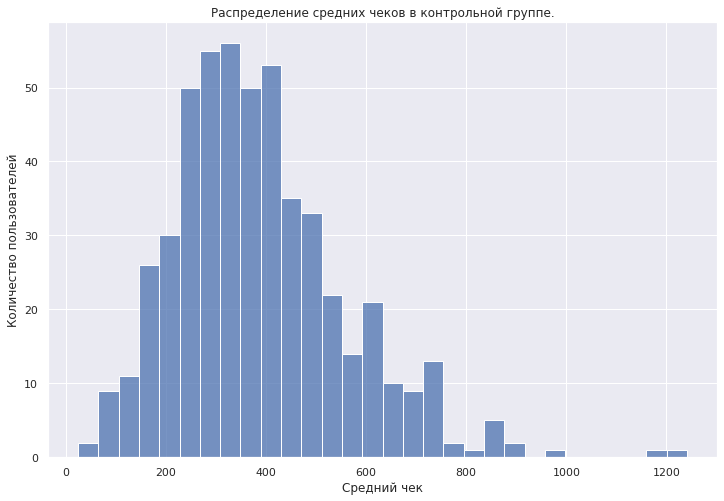

In [130]:
# Изобразим распределение средних чеков контрольной группы на графике.
sns.histplot(data=control_avg_check, x='avg_check', bins = 30);
plt.xlabel('Средний чек')
plt.ylabel('Количество пользователей')
plt.title('Распределение средних чеков в контрольной группе.');

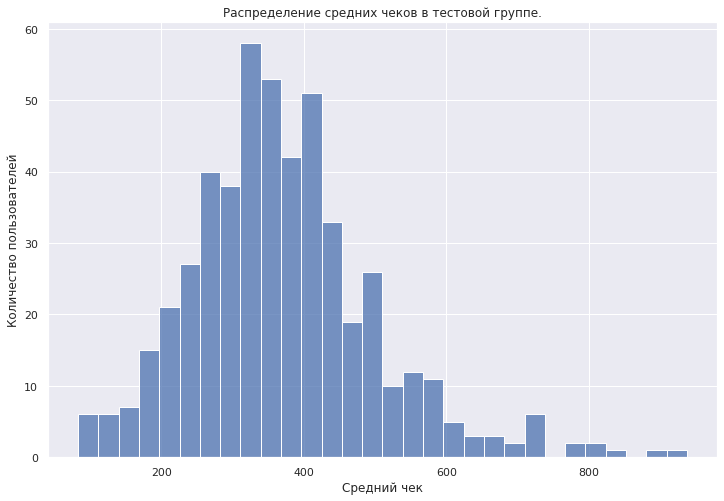

In [131]:
# Изобразим распределение средних чеков тестовой группы на графике.
sns.histplot(data=test_avg_check, x='avg_check', bins=30);
plt.xlabel('Средний чек')
plt.ylabel('Количество пользователей')
plt.title('Распределение средних чеков в тестовой группе.');

In [132]:
# Создаем одномерные массивы из значений средних чеков по группам.
control_array = np.array(control_avg_check.avg_check)
test_array = np.array(test_avg_check.avg_check)

In [133]:
# Проверим распределение в контрольной группе на нормальность.
stats.normaltest(control_array)
# P-value меньше 0.05 => выборка не происходит из нормального распределения.

NormaltestResult(statistic=82.50324998469304, pvalue=1.215197580839215e-18)

In [134]:
# Проверим распределение в тестовой группе на нормальность.
stats.normaltest(test_array)
# P-value меньше 0.05 => выборка не происходит из нормального распределения.

NormaltestResult(statistic=71.62189406107548, pvalue=2.802226997679357e-16)

In [135]:
# Смотрим на однородность дисперсий в выборках.
stats.levene(control_array, test_array)
# P-value меньше 0.05 => отклоняем нулевую гипотезу о равенстве дисперсий.

LeveneResult(statistic=26.849047624726403, pvalue=2.655032016812832e-07)

Итого:
<ul>
<li>Признак в выборках распределен не нормально.
<li>Количество наблюдений в выборках не равно (небольшое различие).
<li>Дисперсии в выборках не однородны.
<ul>

В связи со всем вышесказанным в качестве статистического критерия воспользуемся Bootstrap и сравним медианы выборок.

In [136]:
# Применяем Bootstrap к контрольной группе.
stats.bootstrap((control_avg_check.avg_check, ), np.median)

BootstrapResult(confidence_interval=ConfidenceInterval(low=342.845, high=378.1469267823087), standard_error=8.879097982147474)

In [137]:
# Применяем Bootstrap к тестовой группе.
stats.bootstrap((test_avg_check.avg_check, ), np.median)

BootstrapResult(confidence_interval=ConfidenceInterval(low=344.17, high=368.88), standard_error=6.611223141421128)

Доверительные интервалы медианных значений пересекаются. Значит, мы не можем отклонить нулевую гипотезу о равенстве средних чеков в контрольной и тестовой группах.

### Этап 3. Анализ целевой метрики 2.
Чтобы найти retantion rate, надо найти дату первой покупки для пользователей и выяснить, какой процент покупателей возвращается в сервис в каждый последующий день.

Гипотезы для целевой метрики 2:
<ul>
<li>H_0 - показатель удержания пользователей в контрольной и тестовой группах не отличается.
<li>H_1 - показатель удержания пользователей в контрольной и тестовой группах отличается.    

In [138]:
# Переведем дату создания ордера в нужный формат.
result_orders['time'] = pd.to_datetime(result_orders['time'])

In [139]:
# Уберем отмененные заказы.
result_orders_retantion = result_orders.query('order_id not in @my_filter')
result_orders_retantion

,user_id,order_id,action,time,date,group,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,408.7
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,250.5
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,310.2
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,228.0
5,968,1261,create_order,2022-08-26 00:05:35,2022-08-26,0,430.7
...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03,2022-09-08,1,241.2
4333,1418,59439,create_order,2022-09-08 23:18:05,2022-09-08,1,518.5
4334,1605,59464,create_order,2022-09-08 23:22:27,2022-09-08,0,185.9
4335,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,501.9


In [140]:
# Находим время первой покупки для каждого пользователя, переводим в дату.
temp_min_time = result_orders_retantion.groupby('user_id', as_index=False) \
                                       .agg({'time':'min'}) \
                                       .rename(columns={'time':'first_buy'})
temp_min_time['first_buy'] = temp_min_time['first_buy'].apply(lambda x: x.date())

In [141]:
# Добавляем к нашему датафрейму информацию с датой первой покупки.
result_orders_retention = result_orders_retantion.merge(temp_min_time, on='user_id', how='left')
result_orders_retention

,user_id,order_id,action,time,date,group,price,first_buy
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,408.7,2022-08-26
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,250.5,2022-08-26
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,310.2,2022-08-26
3,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,228.0,2022-08-26
4,968,1261,create_order,2022-08-26 00:05:35,2022-08-26,0,430.7,2022-08-26
...,...,...,...,...,...,...,...,...
3904,990,59422,create_order,2022-09-08 23:13:03,2022-09-08,1,241.2,2022-08-26
3905,1418,59439,create_order,2022-09-08 23:18:05,2022-09-08,1,518.5,2022-08-26
3906,1605,59464,create_order,2022-09-08 23:22:27,2022-09-08,0,185.9,2022-08-26
3907,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,501.9,2022-08-26


In [142]:
# Разделяем датафрейм на контрольную и тестовую группы.
control_retantion = result_orders_retention[result_orders_retention.group == 0]
test_retantion = result_orders_retention[result_orders_retention.group == 1]

In [143]:
# Находим количество уникальных пользователей, совершивших покупку, для каждого дня (пользователи разделены по дате первого
# заказа) в контрольной группе.
control_retantion = control_retantion.groupby(['date', 'first_buy'], as_index=False) \
                                     .agg({'user_id':lambda x: x.nunique()}) \
                                     .sort_values(['date', 'first_buy'])
control_retantion

,date,first_buy,user_id
0,2022-08-26,2022-08-26,496
1,2022-08-27,2022-08-26,79
2,2022-08-27,2022-08-27,2
3,2022-08-28,2022-08-26,67
4,2022-08-28,2022-08-28,3
5,2022-08-29,2022-08-26,78
6,2022-08-29,2022-08-28,1
7,2022-08-30,2022-08-26,69
8,2022-08-30,2022-08-28,1
9,2022-08-30,2022-08-30,3


Как видим, фактически все покупки произошли от пользователей, совершивших первый заказ в первый день. Поэтому считаем retantion rate только для этой группы пользователей.

In [144]:
# Находим retantion rate в контрольной группе (значение 1 убирается, так как это день, относительно которого мы и считаем 
# показатель).
control_retantion = control_retantion.sort_values('first_buy').head(14).sort_values('date').drop(index=0).reset_index(drop=True)
control_retantion['retantion'] = control_retantion.user_id.apply(lambda x: round(x / 496, 2))
control_retantion

,date,first_buy,user_id,retantion
0,2022-08-27,2022-08-26,79,0.16
1,2022-08-28,2022-08-26,67,0.14
2,2022-08-29,2022-08-26,78,0.16
3,2022-08-30,2022-08-26,69,0.14
4,2022-08-31,2022-08-26,52,0.10
5,2022-09-01,2022-08-26,55,0.11
6,2022-09-02,2022-08-26,46,0.09
7,2022-09-03,2022-08-26,46,0.09
8,2022-09-04,2022-08-26,59,0.12
9,2022-09-05,2022-08-26,32,0.06


In [145]:
# Находим количество уникальных пользователей, совершивших покупку, для каждого дня (пользователи разделены по дате первого
# заказа) в тестовой группе.
test_retantion = test_retantion.groupby(['date', 'first_buy'], as_index=False) \
                               .agg({'user_id':lambda x: x.nunique()}) \
                               .sort_values(['date', 'first_buy'])
test_retantion

,date,first_buy,user_id
0,2022-08-26,2022-08-26,487
1,2022-08-27,2022-08-26,123
2,2022-08-27,2022-08-27,6
3,2022-08-28,2022-08-26,128
4,2022-08-28,2022-08-27,1
5,2022-08-28,2022-08-28,3
6,2022-08-29,2022-08-26,128
7,2022-08-29,2022-08-27,1
8,2022-08-29,2022-08-29,1
9,2022-08-30,2022-08-26,93


In [146]:
# Находим retantion rate в тестовой группе (значение 1 убирается, так как это день, относительно которого мы и считаем 
# показатель).
test_retantion = test_retantion.sort_values('first_buy').head(14).sort_values('date').drop(index=0).reset_index(drop=True)
test_retantion['retantion'] = test_retantion.user_id.apply(lambda x: round(x / 487, 2))
test_retantion

,date,first_buy,user_id,retantion
0,2022-08-27,2022-08-26,123,0.25
1,2022-08-28,2022-08-26,128,0.26
2,2022-08-29,2022-08-26,128,0.26
3,2022-08-30,2022-08-26,93,0.19
4,2022-08-31,2022-08-26,85,0.17
5,2022-09-01,2022-08-26,81,0.17
6,2022-09-02,2022-08-26,85,0.17
7,2022-09-03,2022-08-26,83,0.17
8,2022-09-04,2022-08-26,82,0.17
9,2022-09-05,2022-08-26,55,0.11


In [147]:
# Создаем одномерные массивы из значений retantion rate по группам.
control_retantion_array = np.array(control_retantion.retantion)
test_retantion_array = np.array(test_retantion.retantion)

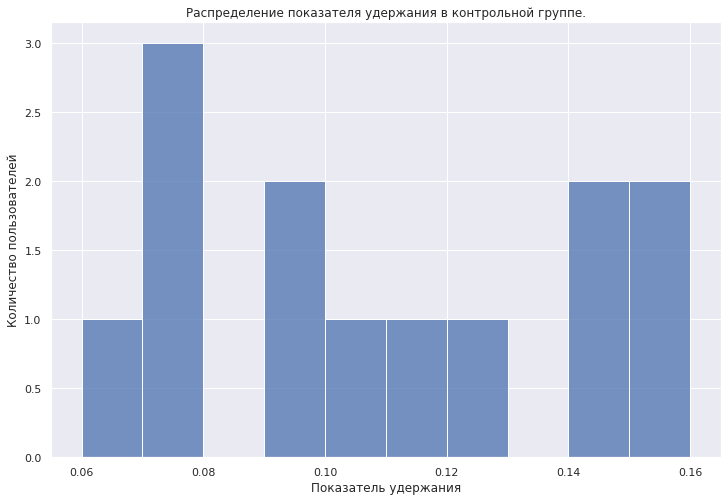

In [153]:
# Изобразим распределение показателя удержания в контрольной группе на графике.
sns.histplot(data=control_retantion, x='retantion', bins = 10);
plt.xlabel('Показатель удержания')
plt.ylabel('Количество пользователей')
plt.title('Распределение показателя удержания в контрольной группе.');

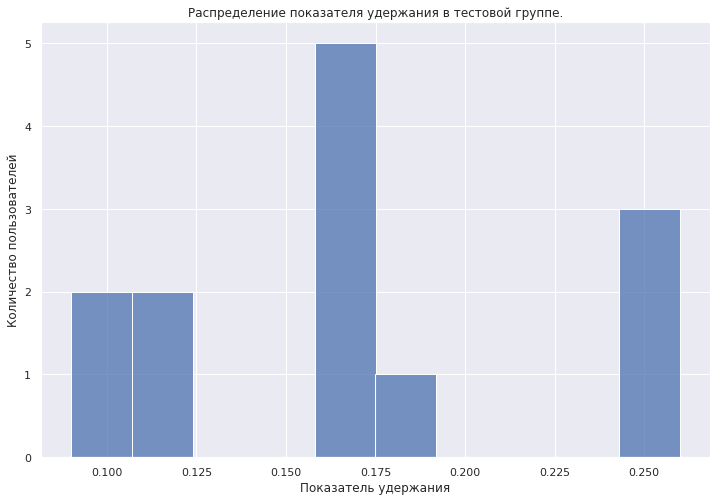

In [154]:
# Изобразим распределение показателя удержания в тестовой группе на графике.
sns.histplot(data=test_retantion, x='retantion', bins = 10);
plt.xlabel('Показатель удержания')
plt.ylabel('Количество пользователей')
plt.title('Распределение показателя удержания в тестовой группе.');

In [150]:
# Смотрим на однородность дисперсий в выборках.
stats.levene(control_retantion_array, test_retantion_array)
# P-value больше 0.05 => оставляем нулевую гипотезу о равенстве дисперсий.

LeveneResult(statistic=1.0615065653075308, pvalue=0.3131436689233086)

Итого:
<ul>
<li>Признак в выборках распределен не нормально.
<li>Количество наблюдений в выборках равно.
<li>Дисперсии в выборках однородны.
<ul>

В связи со всем вышесказанным в качестве статистического критерия воспользуемся непараметрическим U-критерием Манна-Уитни.

In [151]:
# Применяем критерий.
stats.mannwhitneyu(control_retantion_array, test_retantion_array)

MannwhitneyuResult(statistic=24.5, pvalue=0.00214652886712573)

P-value меньше 0.05, значит отклоняем нулевую гипотезу об одинаковом расположении распределений retention rate в группах, при этом мы видим, что случайно взятое значение из тестовой группы будет больше случайно взятого значения из контрольной группы с вероятностью, большей 50% (одна из интерпретаций критерия Манна-Уитни). Значит, мы можем сказать, что retantion rate в тестовой группе статистически больше retantion rate в контрольной группе.

### Этап 4. Выводы.

Мы провели анализ данных, проверили гипотезы и выяснили, что средний чек в тестовой группе и контрольной группах статистически значимо не отличается. При этом показатель удержания клиентов в тестовой группе, по сравнению с контрольной увеличился, что означает, что больше пользователей продолжают пользоваться приложением после первой покупки (при прочих равных именно потому, что им понравилась внедренная рекомендательная система и приложение стало удобнее). В конечном итоге, увеличенный показатель удержания в купе с неизменившимся средним чеком дают рост прибыли для бизнеса.
##### В связи со всем выше сказанным, в заключении я скажу, что стоит включать новую систему рекомендаций на всех пользователей, так как клиентам стало удобнее пользоваться приложением, на что указывает увеличение показателя удержания, а в связи с этим и тем, что средний чек не упал, прибыль бизнеса так же увеличилась.